In [211]:
from IPython.display import HTML


HTML('''
    <script>
        showCode = true;
        function toggleCode() {
            if (showCode) {
                $("div.input").show("500");
                $("#toggleButton").val("Hide Code");
            } else {
                $("div.input").hide("500");
                $("#toggleButton").val("Show Code");
            }
            showCode = !showCode
        }
        $(document).ready(toggleCode());
    </script>
    <form action="javascript:toggleCode()">
    <input id="toggleButton" type="submit" value="Hide Code"></form>
''')

# Ingest log contents

#### I. Configuration

In [2]:
# S3 configuration
_LOGS_S3_REGION = 'us-west-2'
_LOGS_S3_BUCKET = 'bff-logging'

# Number of log files to analyze
_NUMBER_MOST_RECENT_LOGS = 50

# Start of the field header from logs
_LOGS_FIELDS_HEADER = '#Fields:'

#### II. Functions to ingest raw log contents from S3

In [11]:
import gzip
import re
import StringIO

import boto.s3


def get_log_contents_from_s3(number_most_recent_logs):
    """
    Connects to S3, ingests key contents, and returns list of logs.
    """
    # Get desired number of log keys from S3
    connection = boto.s3.connect_to_region(_LOGS_S3_REGION)
    bucket = connection.get_bucket(_LOGS_S3_BUCKET)
    log_keys = bucket.list(prefix='bff-log/')
    log_keys = [l for l in log_keys][-number_most_recent_logs:]
    # Load log contents into memory
    logs_raw = []
    for key in log_keys:
        gzipped = StringIO.StringIO(key.get_contents_as_string())
        reader = gzip.GzipFile(fileobj=gzipped)
        contents = reader.read()
        logs_raw.append(re.split('\n', contents))
        reader.close()
    return logs_raw

#### III. Functions to format raw log contents

In [4]:
import datetime
import json
import urllib


def get_log_fields_from_single_log(log):
    """ Gets the field names from a log file. """
    fields_raw = log[1]
    if re.match(_LOGS_FIELDS_HEADER, fields_raw) is None:
        raise Exception('Expected field header "{s}":  did the log format change?'
            .format(_LOGS_FIELDS_HEADER))
    fields = re.split('\s*', fields_raw)[1:-1]
    return fields


def get_formatted_log_contents_from_raw_logs(logs_raw, log_fields):
    """
    Returns a list of dictionaries, where each dictionary represents the
    formatted contents of a log entry.
    """
    logs = []
    # Step through logs
    for log in logs_raw:
        # Step through entries, ignoring the leading version and field entries
        for entry in log[2:]:
            # Store parsed log
            formatted_entry = _get_formatted_entry_contents(entry, log_fields)
            if formatted_entry is not None:
                logs.append(formatted_entry)
    return logs


# Convenience functions
def _get_formatted_entry_contents(entry, log_fields):
    """
    Returns a dictionary of formatted contents for a single log entry.
    """
    # Return nothing if the entry is empty
    is_empty = entry == ''
    if is_empty:
        return None
    # Split values and assign them to fields
    values = re.split('\s*', entry)[:-1]
    log_dict = {key: value for key, value in zip(log_fields, values)}
    # Decode User-agent
    log_dict['cs(User-Agent)'] = _format_cs_user_agent(log_dict['cs(User-Agent)'])
    # Parse and decode query parameters if available
    log_dict['cs-uri-query'] = _format_cs_uri_query(log_dict['cs-uri-query'])
    # Format datetime object
    log_dict['datetime'] = _format_datetimes(log_dict['date'], log_dict['time'])
    return log_dict


def _format_cs_user_agent(user_agent):
    """ Url decodes the user agent value. """
    return urllib.unquote_plus(urllib.unquote_plus(user_agent))


def _format_cs_uri_query(uri_query):
    """ Formats and url decodes the uri query value. """
    query_dict = {}
    if uri_query != '-':
        query_args = re.split('&', uri_query)
        for arg in query_args:
            key, val_raw = re.split('(?<!ref)=', arg)
            val = urllib.unquote_plus(urllib.unquote_plus(val_raw))
            query_dict.update({key: val})
        query_dict['d'] = json.loads(query_dict['d'])
    return query_dict


def _format_datetimes(date, time):
    """ Formats date and time strings as single object. """
    datetime_str = date + time
    return datetime.datetime.strptime(datetime_str, '%Y-%m-%d%H:%M:%S')

#### IV. Get formatted logs by calling defined functions

In [5]:
logs_raw = get_log_contents_from_s3(_NUMBER_MOST_RECENT_LOGS)
log_fields = get_log_fields_from_single_log(logs_raw[0])
logs = get_formatted_log_contents_from_raw_logs(logs_raw, log_fields)

# Analyze log contents

### Date trends

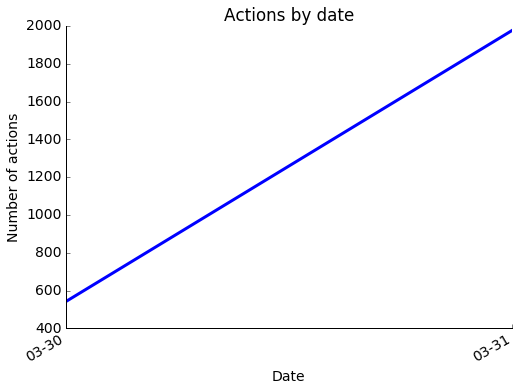

In [7]:
%matplotlib inline

from collections import Counter

from matplotlib.dates import DayLocator, DateFormatter
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

def plot_dates(logs):
    """ Plot dates from log files. """
    # Sort dates and counts
    dates, counts = _format_dates_and_counts(logs)
    # Create plot
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot_date(dates, counts, '-', linewidth=3)
    # Format text
    _format_text(ax, 'Actions by date', 'Date', 'Number of actions')
    # Format dates
    ax.xaxis.set_major_locator(DayLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax.autoscale_view()
    fig.autofmt_xdate()
    # Format axes
    _format_axes(ax)
    plt.show()

    
def _format_dates_and_counts(logs):
    """ From logs, gathers datetimes and gets date counts. """
    datetimes = [log['datetime'].date() for log in logs]
    return _count_and_sort_time_values(datetimes)


def _count_and_sort_time_values(values):
    """ Convenience function for counting and sorting values. """
    counter = Counter(values)
    keys = sorted(counter.keys(), key=lambda k: k)
    counts = [counter[key] for key in keys]
    return keys, counts


def _format_text(ax, title, xlabel, ylabel):
    """ Convenience function for formatting text labels """
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return


def _format_axes(ax):
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return


plot_dates(logs)

### Time trends

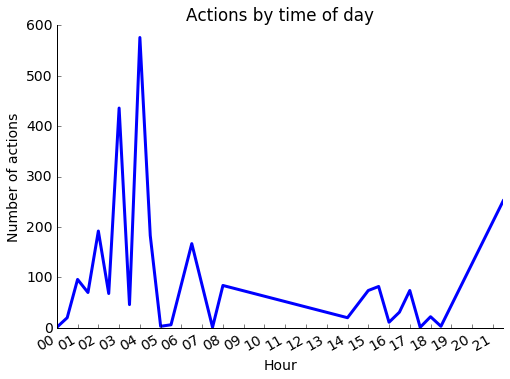

In [8]:
from matplotlib.dates import HourLocator, MinuteLocator


def plot_times(logs):
    """ Plot times from log files. """
    # Sort dates and counts
    times, counts = _format_times_and_counts(logs)
    # Create plot
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot_date(times, counts, '-', linewidth=3)
    # Format text
    _format_text(ax, 'Actions by time of day', 'Hour', 'Number of actions')
    # Format dates
    ax.xaxis.set_major_locator(HourLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%H'))
    ax.autoscale_view()
    fig.autofmt_xdate()
    # Format axes
    _format_axes(ax)
    plt.show()

# Create function to format dates for plotting
def _format_times_and_counts(logs):
    """ From logs, gathers datetimes and gets time counts. """
    times = []
    for log in logs:
        hours = log['datetime'].hour
        minutes_raw = log['datetime'].minute
        minutes = minutes_raw - minutes_raw % 30
        times.append(datetime.datetime(1900, 1, 1, hours, minutes))
    return _count_and_sort_time_values(times)


plot_times(logs)

### State trends

Loading BokehJS ...

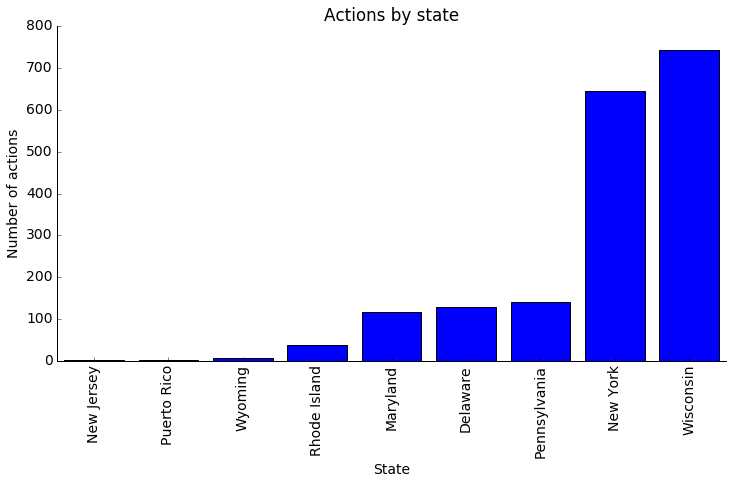

In [70]:
import bokeh.plotting
from bokeh.sampledata.us_states import data as bokeh_states

try:
    del bokeh_states["HI"]
    del bokeh_states["AK"]
except KeyError:
    pass


_NUM_MAP_COLORS = 6


def plot_states(logs):
    """ Plot states from log files. """
    states, counts = _format_states_and_counts(logs)
    _plot_choropleth(states, counts)
    _plot_barchart(states, counts)
    return
    
    
def _plot_choropleth(states, counts):
    """ Create a choropleth """
    # Get alpha values for states
    state_alphas = _get_alpha_values_for_states(states, counts)
    # Create plot
    state_xs = [state["lons"] for state in bokeh_states.values()]
    state_ys = [state["lats"] for state in bokeh_states.values()]
    fig = bokeh.plotting.figure(plot_width=800, plot_height=500)
    fig.patches(
        state_xs, state_ys, fill_color='blue', fill_alpha=state_alphas,
        line_color='black', line_width=0.5)
    # Format axes
    fig.xaxis.visible = None
    fig.xgrid.grid_line_color = None
    fig.yaxis.visible = None
    fig.ygrid.grid_line_color = None
    # Print plot
    bokeh.plotting.output_notebook()
    bokeh.plotting.show(fig)
    return


def _get_alpha_values_for_states(states, counts):
    """ Get alpha values based on relative counts. """
    alpha_values = [.1 + (.9 / _NUM_MAP_COLORS) * idx for idx in range(_NUM_MAP_COLORS)]
    state_alphas = []
    max_count = 1 + max(counts)
    # Step through states
    for state in bokeh_states.values():
        state_name = state['name']
        # State completely transparent if count = 0
        if state_name not in states:
            state_alphas.append(0)
            continue
        # State alpha relative to max if count > 0
        pct_of_max = float(counts[states.index(state_name)]) / max_count
        alpha_idx = int(pct_of_max * 5)
        state_alphas.append(alpha_values[alpha_idx])
    return state_alphas


def _plot_barchart(states, counts):
    """ Create barchart """
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    xs = [.1 + idx for idx in range(len(states))]
    ax.bar(xs, counts, .8)
    # Format text
    _format_text(ax, 'Actions by state', 'State', 'Number of actions')
    # Format plot
    ax.set_xticks([.5 + idx for idx in range(len(states))])
    ax.set_xticklabels(states, rotation='vertical')
    _format_axes(ax)
    plt.show()
    return


# Create function to format dates for plotting
def _format_states_and_counts(logs):
    """ From logs, gathers locations and gets state counts. """
    states = []
    for log in logs:
        location = log['cs-uri-query']['d'].get('Resides', None)
        if location is None:
            continue
        has_comma = re.search(', ', location) is not None
        if has_comma is False:
            continue
        state = re.split(', ', location)[-1]
        has_paren = re.search(' \(', state) is not None
        if has_paren:
            state = re.split(' \(', state)[0]
        states.append(state)
    return _count_and_sort_string_values(states)


def _count_and_sort_string_values(values):
    """ Convenience function for counting and sorting values. """
    counter = Counter(values)
    sorted_items = sorted(counter.items(), key=lambda kv: kv[1])
    keys = [k[0] for k in sorted_items]
    counts = [k[1] for k in sorted_items]
    return keys, counts


plot_states(logs)

### Actions performed

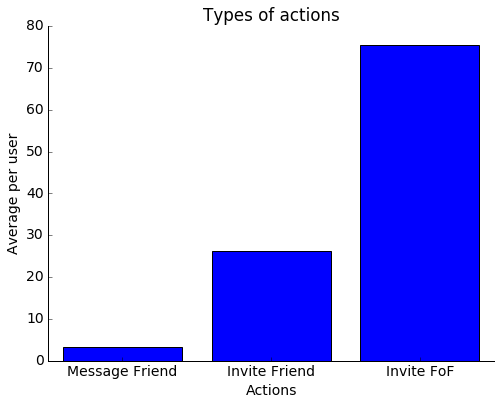

In [83]:
def plot_actions(logs):
    """ Plot actions from log files. """
    # Sort dates and relative counts
    actions, counts = _format_actions_and_counts(logs)
    num_unique = _get_number_unique_users(logs)
    counts = [float(count) / num_unique for count in counts]
    # Create plot
    fig, ax = plt.subplots(figsize=(8, 6))
    xs = [.1 + idx for idx in range(len(actions))]
    ax.bar(xs, counts, .8)
    # Format text
    _format_text(ax, 'Types of actions', 'Actions', 'Average per user')
    # Format plot
    ax.set_xticks([.5 + idx for idx in range(len(actions))])
    xlabels = [' '.join(action) for action in actions]
    ax.set_xticklabels(xlabels)
    _format_axes(ax)
    plt.show()
    return
    

def _format_actions_and_counts(logs):
    """ From logs, gathers actions and friendships. """
    actions = []
    for log in logs:
        data = log['cs-uri-query']['d']
        actions.append((data['act'], data['Friendship']))
    return _count_and_sort_string_values(actions)


def _get_number_unique_users(logs):
    unique_users = set()
    for log in logs:
        unique_users.add(log['c-ip'])
    return len(unique_users)


plot_actions(logs)

In [207]:
# Count the actions each user takes
user_actions = {}
for log in logs:
    user = log['c-ip']
    data = log['cs-uri-query']['d']
    action = data['act'] + ' ' + data['Friendship']
    user_actions.setdefault(user, []).append(action)
user_actions = {user: Counter(actions)
                for user, actions in user_actions.items()}
num_users = float(len(user_actions))

# Print out information about user actions
def _print(value):
    print value, '\t({v}%)'.format(v=int(100*value/num_users))

print 'Users taking no actions:\t\t', 
temp = sum([len(actions) == 0 for actions in user_actions.values()])
_print(temp)

print '... sending at least one message:\t',
temp = sum([actions.get('Message Friend', 0) > 0
            for actions in user_actions.values()])

_print(temp)

print '... sending at least one invite:\t',
temp = sum([actions.get('Invite Friend', 0) + actions.get('Invite FoF', 0) > 0
            for actions in user_actions.values()])
_print(temp)

print '... taking both actions:\t\t',
temp = sum([actions.get('Invite Friend', 0) + actions.get('Invite FoF', 0) > 0
            and actions.get('Message Friend', 0) > 0
            for actions in user_actions.values()])
_print(temp)

print '\n'

print 'Users inviting at least one friend:\t',
temp = sum([actions.get('Invite Friend', 0) > 0
            for actions in user_actions.values()])
_print(temp)

print '... inviting at least one FoF:\t\t',
temp = sum([actions.get('Invite FoF', 0) > 0
            for actions in user_actions.values()])
_print(temp)

print '... inviting both friends and FoFs:\t',
temp = sum([actions.get('Invite FoF', 0) > 0
            and actions.get('Invite Friend', 0) > 0
            for actions in user_actions.values()])
_print(temp)

Users taking no actions:		0 	(0%)
... sending at least one message:	9 	(37%)
... sending at least one invite:	21 	(87%)
... taking both actions:		6 	(25%)


Users inviting at least one friend:	15 	(62%)
... inviting at least one FoF:		10 	(41%)
... inviting both friends and FoFs:	4 	(16%)
